<b style="color:White; font-size:24px;">Libraries</b>



In [6]:
import random, pywt, statistics
import numpy as np
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew, kurtosis
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

<b style="color:White; font-size:24px;">Constants </b>

In [7]:
FS = 360
LOWCUT = 0.5
HIGHCUT = 40
ORDER = 4
WAVELET_LEVEL = 2
WAVELET_DB = 'db3'

In [8]:
LBBB_test_path = './Data/Normal&LBBB/LBBB_Test.txt'
LBBB_train_path = './Data/Normal&LBBB/LBBB_Train.txt'
normal_test_path = './Data/Normal&LBBB/Normal_Test.txt'
normal_train_path = './Data/Normal&LBBB/Normal_Train.txt'

In [9]:
def getDataEntries(filename):
    data = []
    with open(filename, "r") as file:
        for line in file:
            parts = line.strip().split('|')
            data.append(parts)
    data = [i[:len(i)-1] for i in data]
    new_data = []
    for inner_list in data:
        new_inner_list = [float(element) for element in inner_list]
        new_data.append(new_inner_list)
    return new_data


In [10]:
def plot_sample(data, label = "Signal"):
    fig, axes = plt.subplots(1, len(data), figsize=(15, 2), sharey=True)
    i = 0
    for d in data:
        t = np.linspace(0, FS, len(d))
        axes[i].plot(t, d)
        axes[i].set_title(f"{label} {i+1}")
        axes[i].grid(True)
        i+=1
    plt.tight_layout()
    plt.show()

 <b style="color:White; font-size:24px;">Reading Data</b>

In [11]:
# reading data and constructing their labels
LBBB_test_data = getDataEntries(LBBB_test_path)
LBBB_target_test = ["LBBB" for i in range(len(LBBB_test_data))]

normal_test_data = getDataEntries(normal_test_path)
normal_target_test = ["Normal" for i in range(len(normal_test_data))]

LBBB_train_data = getDataEntries(LBBB_train_path)
LBBB_target_train = ["LBBB" for i in range(len(LBBB_train_data))]

normal_train_data = getDataEntries(normal_train_path)
normal_target_train = ["Normal" for i in range(len(normal_train_data))]

print(len(LBBB_train_data))


399


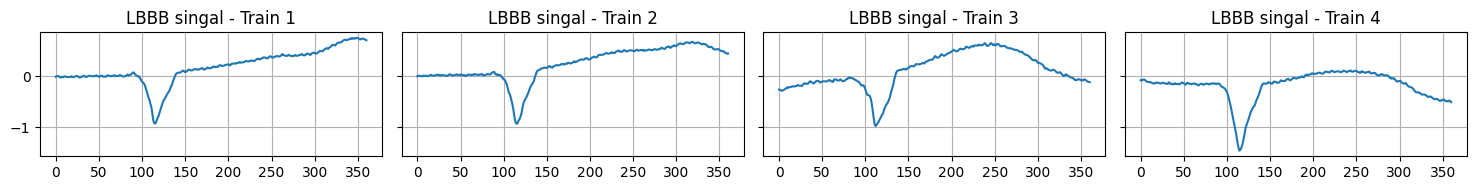

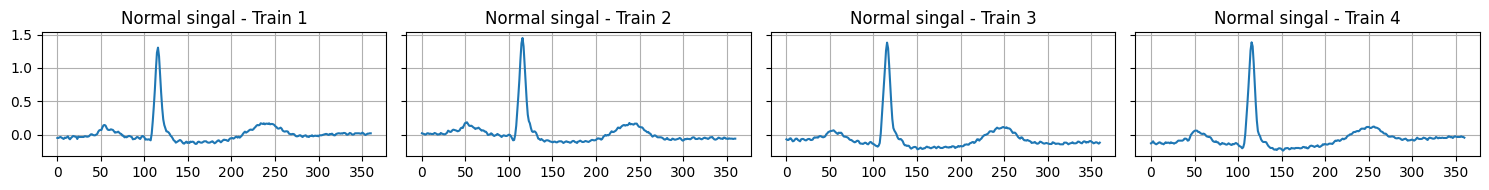

In [12]:
plot_sample(LBBB_train_data[0:4], "LBBB singal - Train")
plot_sample(normal_train_data[0:4], "Normal singal - Train")

<b style="color:White; font-size:24px;">Preprocessing</b>

In [13]:
def remove_duplicates(data):
    new_data = []
    seen = set()
    for row in data:
        entry = tuple(row) 
        if entry not in seen:
            seen.add(entry)
            new_data.append(list(row)) 
    return new_data

In [14]:
# mean removal to remove signal shifting
def mean_removal(data):
    new_data = []
    for row in data:
        processed_row = []
        mean = statistics.mean(row)
        for sample in row:
            processed_row.append(sample - mean)
        new_data.append(processed_row)
    return new_data


In [15]:
# signal normalization from -1 to 1 to transform features to be on a similar scale
def normalize_signal(data):
    new_data = []
    for row in data:
        data = np.array(row)
        x_min = data.min()
        x_max = data.max()
        processed_row = 2 * (data - x_min) / (x_max - x_min) - 1
        new_data.append(processed_row)
    return new_data

In [16]:
def butter_bandpass_filter(data):
    new_data = []
    for row in data: 
        # deviding by nyquist freq to prevent aliasing 
        nyquist = 0.5 * FS  
        low = LOWCUT / nyquist
        high = HIGHCUT / nyquist
        b, a = butter(ORDER, [low, high], btype='band')
        # apply the filter to the signal with zero phase shift
        new_data.append(filtfilt(b, a, row)) 
    return new_data

In [17]:
def preprocess(data):
    new_data = remove_duplicates(data)
    new_data = mean_removal(new_data)
    new_data = butter_bandpass_filter(new_data)
    new_data = normalize_signal(new_data)
    return new_data

<b style="color:White; font-size:24px;">preprocessing train and test data</b>

In [18]:
normal_train_data = preprocess(normal_train_data)
normal_target_train =  ["Normal" for i in range(len(normal_train_data))]
# print("lenth of train lbb before preprocessing",len(LBBB_train_data))
# there's around 200 sample duplicated in lbbb train data
LBBB_train_data = preprocess(LBBB_train_data)
LBBB_target_train =  ["LBBB" for i in range(len(LBBB_train_data))]
# print("lenth of train lbb after preprocessing",len(LBBB_train_data))
LBBB_test_data = preprocess(LBBB_test_data)
LBBB_target_test =  ["LBBB" for i in range(len(LBBB_test_data))]

normal_test_data = preprocess(normal_test_data)
normal_target_test =  ["Normal" for i in range(len(normal_test_data))]

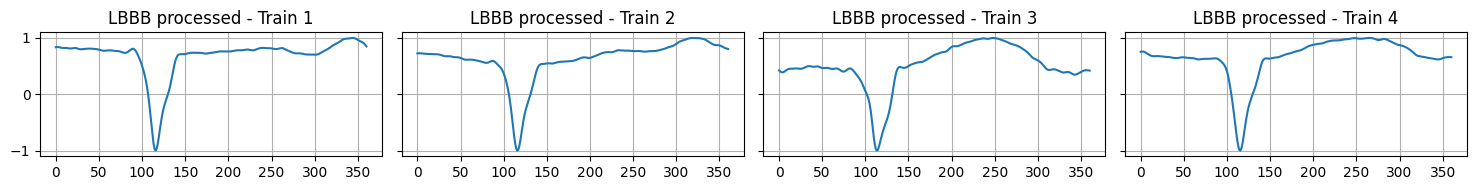

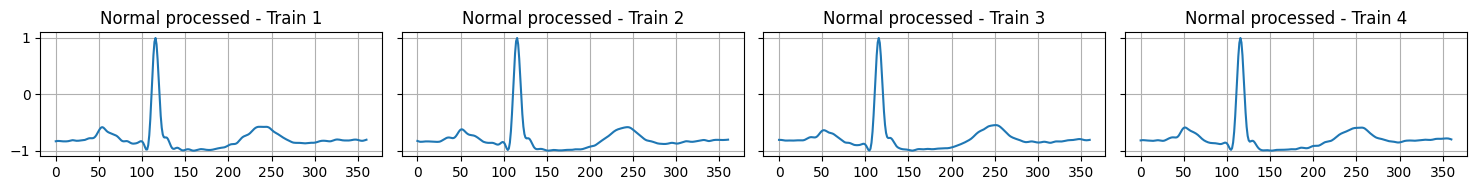

In [19]:
plot_sample(LBBB_train_data[0:4], "LBBB processed - Train")
plot_sample(normal_train_data[0:4], "Normal processed - Train")

<b style="color:White; font-size:24px;">combine and shuffle data</b>    

In [20]:
print(len(LBBB_train_data))
print(len(normal_train_data))
def combine_shuffle(data1, data2, target1, target2):
    data1.extend(data2)
    target1.extend(target2)
    
    return target1, data1

200
200


In [21]:
test_labels, test_data = combine_shuffle(LBBB_test_data, normal_test_data, LBBB_target_test, normal_target_test)
print(LBBB_target_train)
print(normal_target_train)
train_labels, train_data = combine_shuffle(LBBB_train_data, normal_train_data, LBBB_target_train, normal_target_train)

['LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB', 'LBBB',

<b style="color:White; font-size:24px;">Feature Extraction(wavelet)</b>    

In [22]:
# coeffs_trainstructs -> [a, d1, d2, d3, d4, ..]
coeffs_test = pywt.wavedec(test_data, wavelet=WAVELET_DB, level=WAVELET_LEVEL)
coeffs_train = pywt.wavedec(train_data, wavelet=WAVELET_DB, level=WAVELET_LEVEL)

In [23]:
a_train = coeffs_train[0]
details_train = coeffs_train[1:]

a_test = coeffs_test[0]
details_test = coeffs_test[1:]

In [24]:
def compute_statistics(values):
    # Ensure values is a numpy array for easier calculations
    values = np.array(values)

    min_val = np.min(values)
    max_val = np.max(values)
    mean_val = np.mean(values)
    median_val = np.median(values)
    std_dev = np.std(values)
    skewness = skew(values)
    kurt = kurtosis(values)

    # min - max - mean - median - std deviation - skew - kurt
    return [min_val, max_val, mean_val, median_val, std_dev, skewness, kurt]

In [25]:
train_data = [compute_statistics(a_train[i]) for i in range(len(a_train))]
test_data = [compute_statistics(a_test[i]) for i in range(len(a_test))]

print(train_data[0])
print(test_data[0])

features = ["Min", "Max", "Mean", "Median", "Standard Deviation", "Skewness", "Kurtosis"]
train_data = pd.DataFrame(train_data, columns=features)
test_data = pd.DataFrame(test_data, columns=features)


[-1.8432180277599872, 1.9984719916261577, 1.3835162169777926, 1.5547965069499585, 0.6838637585778687, -3.2897738613852883, 10.806213596911642]
[-1.98648168677268, 1.9595826776137195, -0.4565275702150949, -0.4648703224644775, 0.7402872956676148, 0.8322249636412195, 1.4292153879153373]


<b style="color:White; font-size:24px;">visualization</b>    

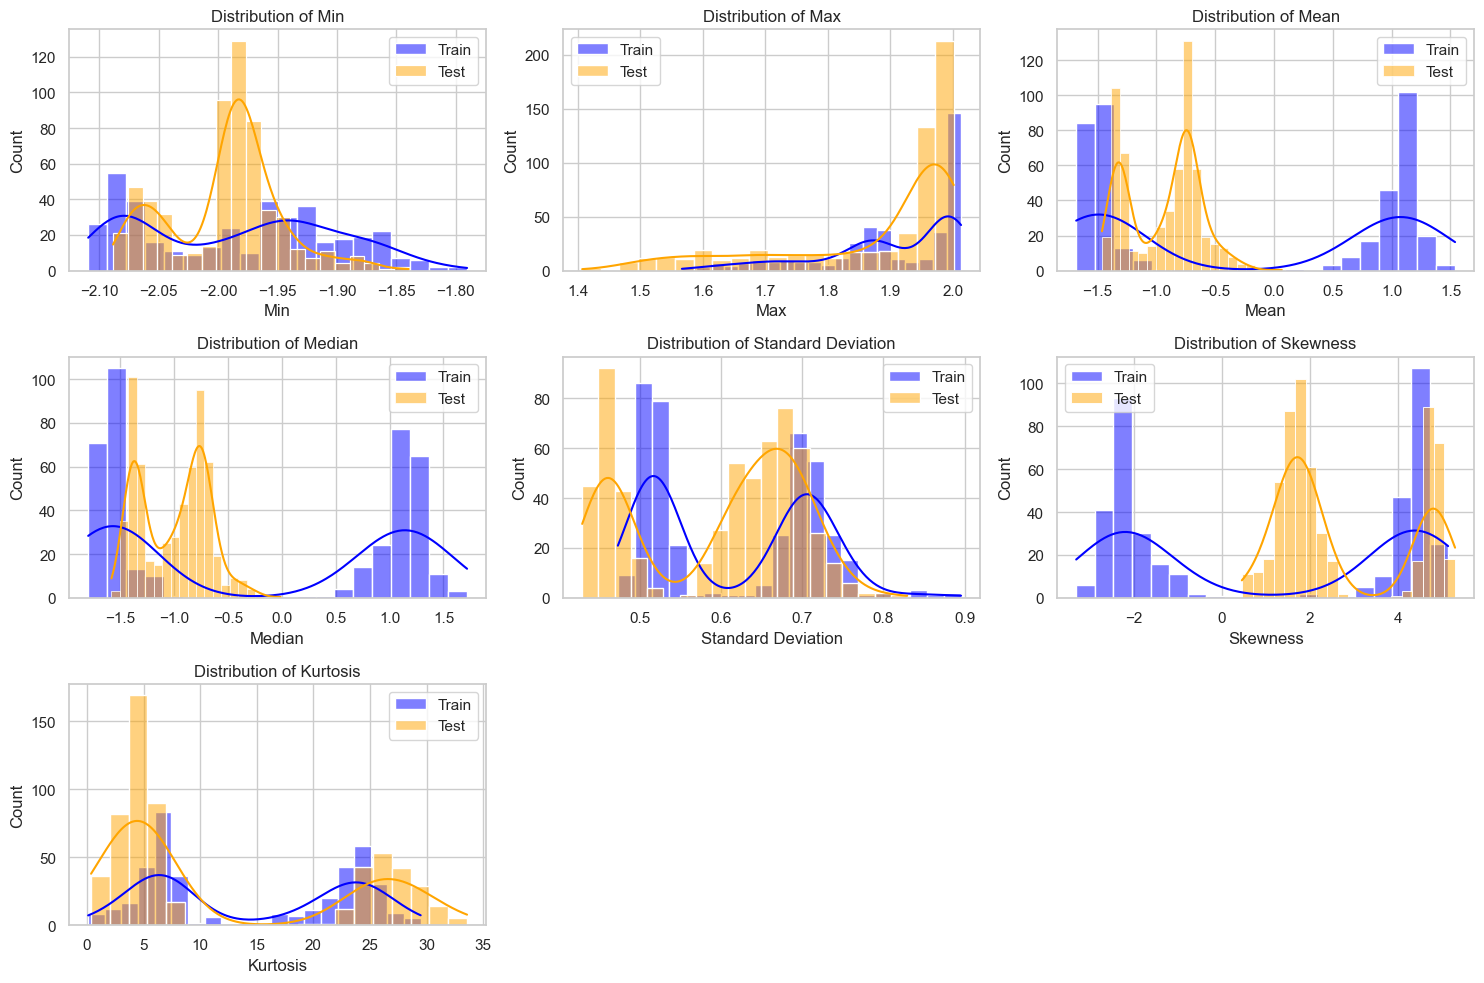

In [ ]:
# Set the style for the plots
sns.set(style="whitegrid")

# Histograms for each feature in the training data
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features):
    plt.subplot(3, 3, i + 1)
    sns.histplot(train_data[feature], kde=True, bins=20, color='blue', label='Train')
    sns.histplot(test_data[feature], kde=True, bins=20, color='orange', label='Test')
    plt.title(f'Distribution of {feature}')
    plt.legend()
plt.tight_layout()
plt.show()

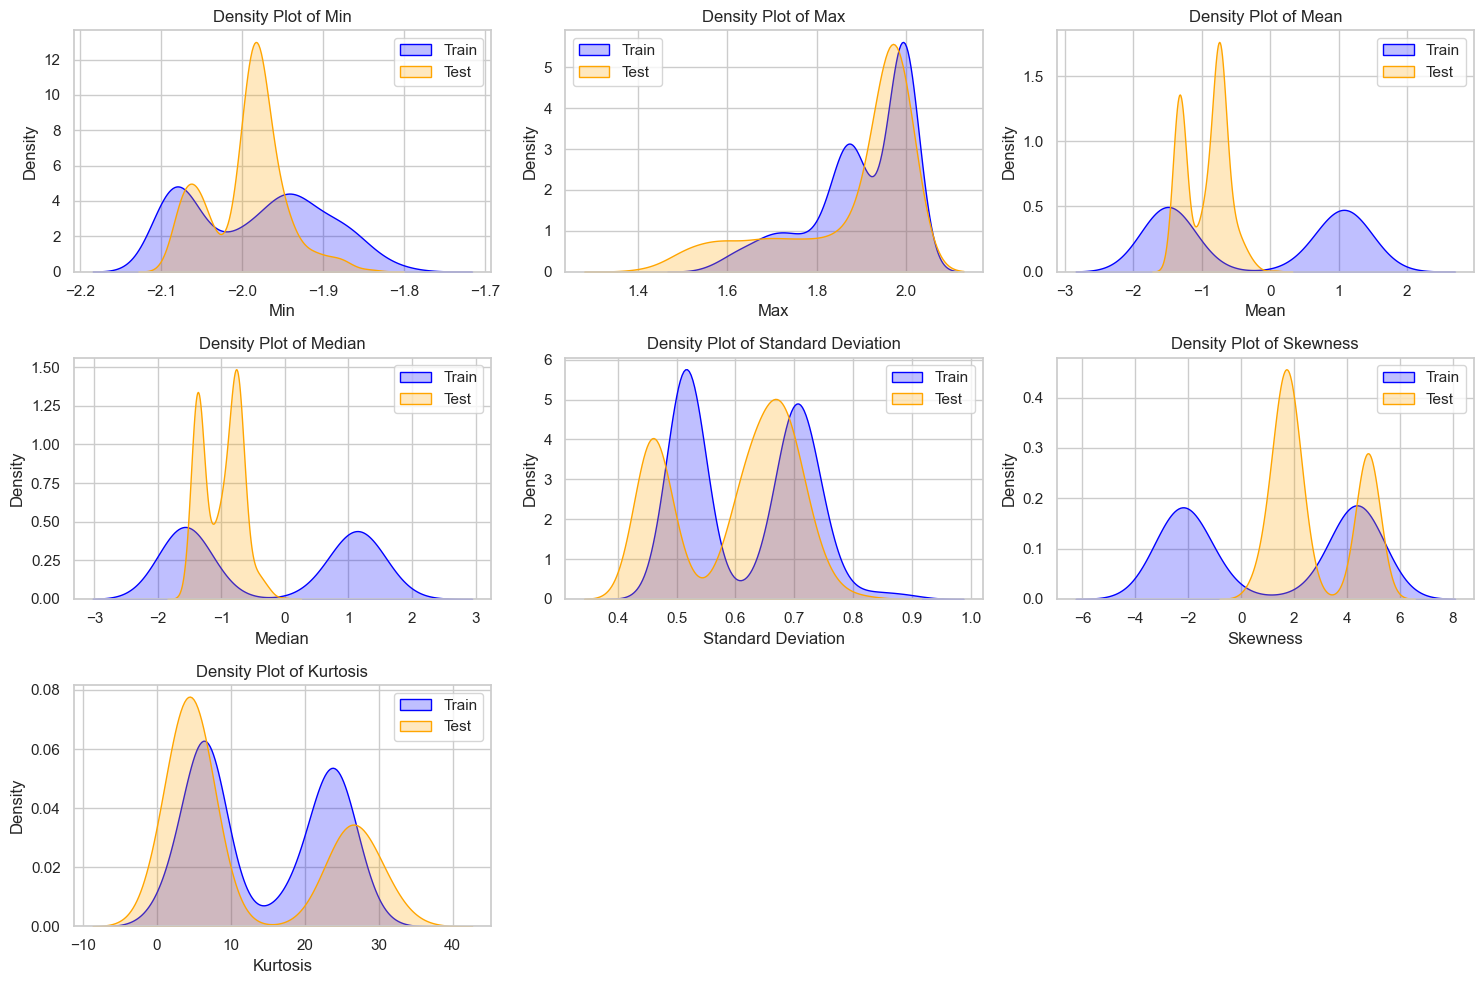

In [27]:
# Density plot for features
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features):
    plt.subplot(3, 3, i + 1)
    sns.kdeplot(train_data[feature], fill=True, color="blue", label='Train')
    sns.kdeplot(test_data[feature], fill=True, color="orange", label='Test')
    plt.title(f'Density Plot of {feature}')
    plt.legend()
plt.tight_layout()
plt.show()

<b style="color:White; font-size:24px;">Classification</b>    

##### KNN

In [28]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(train_data, train_labels)
train_prediction = knn.predict(train_data)
train_accuracy = accuracy_score(train_labels, train_prediction)

KNN Results
train accuracy = 0.99
test accuracy = 0.9949494949494949


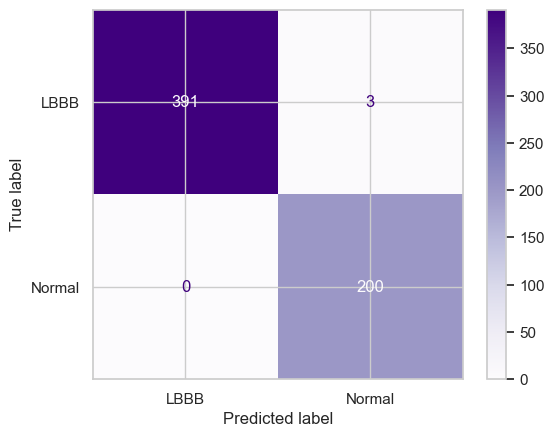

In [29]:
test_prediction = knn.predict(test_data)
test_accuracy = accuracy_score(test_labels, test_prediction)
# print(test_labels)
# print("\n\n\n")
# print(test_prediction)

cm = confusion_matrix(test_labels, test_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(test_labels))
disp.plot(cmap="Purples")

print("KNN Results")
print(f"train accuracy = {train_accuracy}")
print(f"test accuracy = {test_accuracy}")

##### SVM

In [30]:
svm_model = SVC(kernel='rbf', C=0.5, gamma='scale')
svm_model.fit(train_data, train_labels)

SVC(C=0.5)

SVM Results
train accuracy = 0.9925
test accuracy = 0.9713804713804713


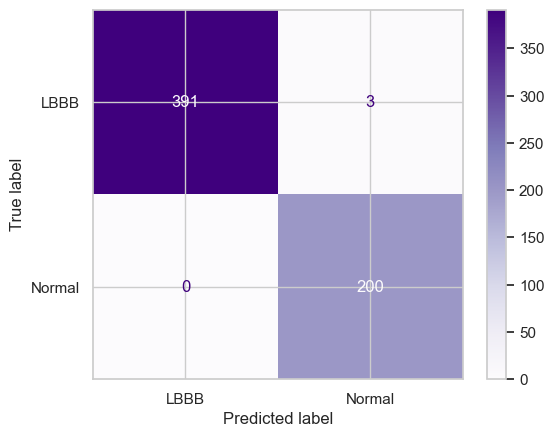

In [31]:
test_pred = svm_model.predict(test_data)
train_pred = svm_model.predict(train_data)

test_accuracy = accuracy_score(test_labels, test_pred)
train_accuracy = accuracy_score(train_labels, train_pred)


print("SVM Results")
print(f"train accuracy = {train_accuracy}")
print(f"test accuracy = {test_accuracy}")

cm = confusion_matrix(test_labels, test_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(test_labels))
disp.plot(cmap="Purples")


##### Random Forest Classifier 

Random Forest Results
Train Accuracy: 0.995
Test Accuracy: 0.9090909090909091


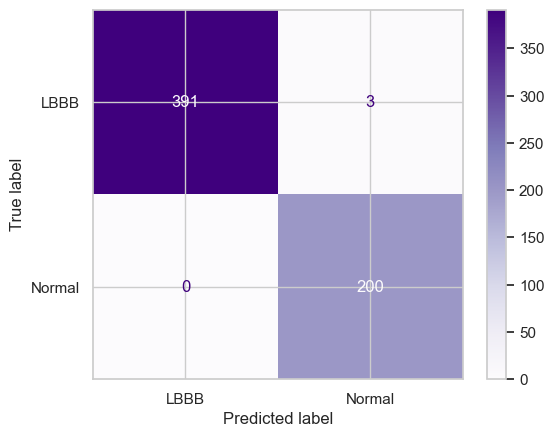

In [32]:

rf = RandomForestClassifier(n_estimators=1, random_state=42,max_depth=1)
rf.fit(train_data, train_labels)

# Evaluate on the training set for Random Forest
train_prediction_rf = rf.predict(train_data)
train_accuracy_rf = accuracy_score(train_labels, train_prediction_rf)

# Evaluate on the test set for Random Forest
test_prediction_rf = rf.predict(test_data)
test_accuracy_rf = accuracy_score(test_labels, test_prediction_rf)

# Display results for Random Forest
print("Random Forest Results")
print(f"Train Accuracy: {train_accuracy_rf}")
print(f"Test Accuracy: {test_accuracy_rf}")

cm = confusion_matrix(test_labels, test_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(test_labels))
disp.plot(cmap="Purples")
